<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">MNIST: CNN</h1>
</div>

Problem Type: Multi-classification

## Evaluation Metric

In [1]:
# Black formatter https://black.readthedocs.io/en/stable/

! pip install nb-black > /dev/null

%load_ext lab_black

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Configuration</h1>
</div>

In [2]:
TARGET = "label"

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Import Libraries</h1>
</div>

A best practise is to include all libraries here.  However, I will put a few imports farther down where they are first used so beginners can learn with an "as needed" approach.

In [3]:
import os
import time
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

# Visualization Libraries
import matplotlib.pylab as plt
import seaborn as sns

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Library</h1>
</div>

Creating a few functions that we will reuse in each project.

In [4]:
def read_data(path):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    submission_df = pd.read_csv(data_dir / "sample_submission.csv")

    print(f"train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
    print(f"test data : Rows={test.shape[0]}, Columns={test.shape[1]}")
    return train, test, submission_df

In [5]:
def create_submission(model_name, target, preds, is_log_target=False):
    if is_log_target:
        #         preds = np.exp(preds)
        preds = np.expm1(preds)

    sample_submission[target] = preds
    if len(model_name) > 0:
        sample_submission.to_csv(f"submission_{model_name}.csv", index=False)
    else:
        sample_submission.to_csv(f"submission.csv", index=False)

    return sample_submission[:5]

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score


def show_scores(gt, yhat):
    f1 = f1_score(gt, yhat, average="macro")
    mse = mean_squared_error(gt, yhat)
    mae = mean_absolute_error(gt, yhat)
    rmse = np.sqrt(mse)
    #     r2_square = r2_score(gt, yhat)

    print(f"f1: {f1:.4f}")

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Load Train/Test Data</h1>
</div>

- train.csv - Data used to build our machine learning model
- test.csv - Data used to build our machine learning model. Does not contain the target variable
- sample_submission.csv - A file in the proper format to submit test predictions

In [7]:
train, test, sample_submission = read_data("../input/digit-recognizer")

train data: Rows=42000, Columns=785
test data : Rows=28000, Columns=784


In [8]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
FEATURES = [
    col
    for col in train.columns
    if col
    not in [
        "Id",
        TARGET,
        #         TARGET_ENC,
    ]
]

In [10]:
y = train[TARGET]
X = train[FEATURES].copy()

X_test = test[FEATURES].copy()

In [11]:
# Normalize the data
X = X / 255.0
X_test = X_test / 255.0

In [12]:
X = X.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

In [13]:
# X[:3]

In [14]:
from keras.utils.np_utils import to_categorical

y = to_categorical(y)

In [15]:
y[:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=42,
)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((37800, 28, 28, 1), (37800, 10), (4200, 28, 28, 1), (4200, 10))

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Create Models</h1>
</div>

In [17]:
### import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


def get_tf_model01(x_shape):
    print(f"x_shape=")
    #     input_shape = (height, width, channels)
    inputs = keras.Input(shape=(28, 28, 1))

    x = keras.layers.Conv2D(
        64,
        kernel_size=3,
        activation="relu",
        padding="same",
        input_shape=(28, 28, 1),
        kernel_initializer="he_normal",
    )(inputs)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(
        64,
        kernel_size=3,
        activation="relu",
        padding="same",
        kernel_initializer="he_normal",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    #     x = keras.layers.MaxPooling2d((2, 2))(x)
    #     x = keras.layers.Conv2D(
    #         128, activation="relu", padding="same", kernel_initializer="he_normal"
    #     )(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.BatchNormalization()(x)

    #     x = keras.layers.Dense(128, activation="relu")(x)

    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    #     x = keras.layers.Dropout(0.1)(x)

    outputs = keras.layers.Dense(10, activation="softmax")(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        loss="categorical_crossentropy",
        optimizer="rmsprop",
        metrics=["accuracy"],
    )

    #     model.compile(
    #         optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    #         loss="mean_absolute_error",
    #     )

    return model

In [18]:
X_train.shape[1]

28

In [19]:
X.shape[0]

42000

In [20]:
model = get_tf_model01(x_shape=(28, 28))

model.summary()

x_shape=
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)           

2022-07-17 15:18:54.577639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 15:18:54.685656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 15:18:54.686366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 15:18:54.687890: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [21]:
%%time

history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=10,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2
)

2022-07-17 15:18:57.759710: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-07-17 15:18:59.915558: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


473/473 [==============================] - 12s 7ms/step - loss: 0.1760 - accuracy: 0.9542 - val_loss: 0.0950 - val_accuracy: 0.9729
Epoch 2/10
473/473 [==============================] - 3s 7ms/step - loss: 0.0574 - accuracy: 0.9821 - val_loss: 0.0535 - val_accuracy: 0.9836
Epoch 3/10
473/473 [==============================] - 4s 8ms/step - loss: 0.0391 - accuracy: 0.9879 - val_loss: 0.0602 - val_accuracy: 0.9813
Epoch 4/10
473/473 [==============================] - 3s 6ms/step - loss: 0.0293 - accuracy: 0.9910 - val_loss: 0.0602 - val_accuracy: 0.9824
Epoch 5/10
473/473 [==============================] - 3s 6ms/step - loss: 0.0247 - accuracy: 0.9928 - val_loss: 0.0549 - val_accuracy: 0.9835
Epoch 6/10
473/473 [==============================] - 3s 7ms/step - loss: 0.0176 - accuracy: 0.9946 - val_loss: 0.0591 - val_accuracy: 0.9856
Epoch 7/10
473/473 [==============================] - 3s 7ms/step - loss: 0.0151 - accuracy: 0.9953 - val_loss: 0.0466 - val_accuracy: 0.9889
Epoch 8/10
473/4

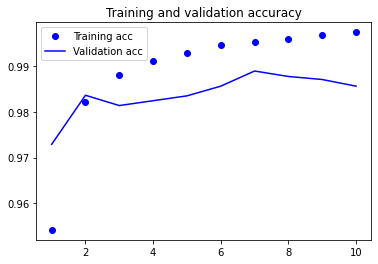

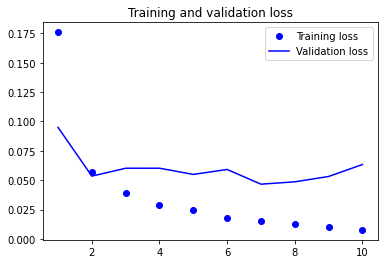

In [22]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

## Predict and Score

In [23]:
test_loss, test_acc = model.evaluate(X_valid, y_valid)
test_acc

132/132 [==============================] - 0s 3ms/step - loss: 0.0454 - accuracy: 0.9864


0.9864285588264465

In [24]:
valid_preds = model.predict(X_valid)
valid_preds[:5]

array([[5.30582298e-08, 4.65914463e-09, 5.63776496e-07, 2.32324382e-07,
        1.43650269e-09, 5.69421443e-09, 1.48852164e-09, 2.28751307e-09,
        9.99999046e-01, 6.76443648e-08],
       [1.46022181e-08, 9.99999046e-01, 1.45252734e-08, 3.76396372e-08,
        8.09812150e-07, 1.05719124e-07, 1.51044706e-08, 5.65113023e-09,
        1.15802496e-08, 2.31181847e-08],
       [7.06324528e-08, 1.93007779e-08, 3.47993314e-08, 1.52322300e-05,
        1.48746005e-06, 5.46676006e-07, 1.02396820e-08, 1.39450117e-06,
        5.54899504e-09, 9.99981165e-01],
       [1.18903891e-07, 6.16261620e-09, 1.83456120e-06, 1.69641510e-06,
        2.40136815e-05, 1.69604641e-06, 5.15119325e-08, 3.67464847e-04,
        5.37328404e-09, 9.99603093e-01],
       [4.37114477e-06, 1.60062697e-07, 5.03921456e-06, 2.94643155e-06,
        1.34323315e-07, 3.22327224e-07, 1.18771432e-07, 3.63003601e-08,
        9.99985695e-01, 1.13566682e-06]], dtype=float32)

In [25]:
valid_preds = np.argmax(valid_preds, axis=1)

In [26]:
# show_scores(y_valid, valid_preds)

In [27]:
preds = model.predict(X_test)
preds[:5]

array([[1.30181007e-07, 5.65698377e-09, 9.99998689e-01, 5.94973093e-09,
        1.86369917e-07, 2.34041622e-08, 3.79722053e-07, 5.76549553e-07,
        5.00368191e-09, 1.24229595e-08],
       [9.99978542e-01, 2.83778235e-07, 5.62378126e-08, 8.36760705e-08,
        5.36068212e-09, 1.25450815e-05, 6.41506460e-07, 7.58401802e-06,
        4.83881095e-08, 2.73194615e-07],
       [2.07415987e-08, 3.12364114e-06, 3.27075031e-05, 5.71369446e-06,
        4.18553973e-05, 7.72653766e-06, 1.81710309e-08, 9.05355250e-07,
        6.77090384e-09, 9.99907970e-01],
       [9.09877181e-01, 8.67203127e-08, 4.73686047e-02, 5.03604424e-05,
        1.14375280e-06, 1.61134960e-06, 3.10451264e-06, 3.27717606e-03,
        2.23732841e-05, 3.93983535e-02],
       [1.50472124e-09, 1.14958301e-08, 4.53430715e-07, 9.99999046e-01,
        1.29804496e-08, 1.56767371e-07, 8.27000246e-09, 1.41741898e-08,
        2.43496725e-08, 2.24999212e-07]], dtype=float32)

In [28]:
preds = np.argmax(preds, axis=1)

## Submission

In [29]:
# Different TARGET name used in test.csv
ss = create_submission("", "Label", preds)
ss

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
